In [1]:
import numpy as np
from datetime import timedelta
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot
from datetime import date

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as mpl

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn import preprocessing as pp
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__
%load_ext skip_kernel_extension

In [2]:
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_eval_df,
convert_to_sample_time_feature,
average_over_year,
average_over_day)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_learning_curves,
)

# Project Outline


- [Introduction](#introduction)
- [Analyzing Energy dataset](#analyzing-energy-dataset)
- [Analyzing Weather Data](#analyzing-weather-dateset)
- [Feature engineering](#feature-engineering)
- [Baseline models](#baseline-models)
  - [SARIMAX](#sarimax)
  - [SVM](#svm)
- [Advanced models](#advanced-models)
  - [Simple NN](#simple-nn)
  - [RNN](#rnn)
  - [LSTM](#lstm)
- [Hyperparameter Tuning](#hyperparameter-tuning)
- [Conclusion and outlook](#conclusion-and-outlook)


# Introduction


"Climate change is one of the greatest challenges facing humanity, and we, as machine learning experts,
may wonder how we can help. Here we describe how machine learning can be a powerful tool in
reducing greenhouse gas emissions and helping society adapt to a changing climate. \
From smart grids to disaster management, we identify high impact problems where existing gaps can be filled by machine
learning, in collaboration with other fields. Our recommendations encompass exciting research questions
as well as promising business opportunities. We call on the machine learning community to join
the global effort against climate change." \
[David Rolnick et. al., 2019, Tackling Climate Change with Machine Learning](https://arxiv.org/abs/1906.05433)

"This dataset contains 4 years of electrical consumption, generation, pricing, and weather data for Spain. Consumption and generation data was retrieved from ENTSOE a public portal for Transmission Service Operator (TSO) data. Settlement prices were obtained from the Spanish TSO Red Electric España. Weather data was purchased as part of a personal project from the Open Weather API for the 5 largest cities in Spain and made public here." \
[Nicholas Jhana, 2019, Hourly energy demand generation and weather](https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather)

As described, in this project we are presented with two files, containing electrical consumption, generation, pricing and weather data for the region of Spain. \
In total there are up to 45 columns/features in the dataset and the data for each feature is hourly collected from 2015 to 2018, which results in 35064 timesteps.
With a dataset of this size and detail, it is only natural to thing about the application of Machine Learning and Neural Networks. 

On one hand it is interesting to forecast the electrical prices, especially for businesses. On the other hand the prediction of electrical consumption can play a crucial role in our fight against global warming. With accurate predictions on the electrical load and sufficient storage capacities, renewable energy sources, where energy production heavily depends on weather, can be planned ahead in time, stored and used later on, which reduces the necessity for other energy generation methods. In turn this might also have an influence on the price. \
Therefore it is interesting to investigate the dependencies between weather, energy generation, consumption and pricing. \
From intuition one might say that the weather and energy consumption are the most basic and indepent variables in this project, because the energy generation from renewable energy sources are dependent from the weather. The increase and decrease of energy prices depends on the supply and demand, or in our case the generation and consumption. 


![energy graph](energy.jpg)

There are many ways to tackle a problem of this size and complexity. \
So first of all, we should define the goals of this project. This dataset is very suited for short term load forecasting, since the overall dataset has a length of 4 years and the resolution is down to hours. The model should be able to predict features for up to 24 hours into the future. \
For this project we are going to start with analyzing the dataset with statistical methods to get a feel for the dataset itself. \
And with a dataset that rich in features, it would be very beneficial apply Feature engineering methods like Correlation Analysis and Dimensionality Reduction to compress the dataset. \
With data like Weather and Energy demand it is worthwhile to look into seasonal trends and patterns and apply a Decomposition to the dataset. Furthermore, it would be practical to look into the history dependcy of the data and apply Autocorrelation and Partial Autocorrelation functions to analyze the dataset. \
For the Basemodel I choose to approach the task as a Regression Problem and model it with the SARIMAX-Model and the SVR-Model. \
The advanced model will be a neural network. And for this NN we will investigate different architectures to find the most suitable Model for this task. We especially will look into recurrent neural networks for their capability to process past data to predict the future. Furthermore, we will model it in a way, that a direct multistep prediction is possible.\

![model graph](DDE_graphs_1.png)

In [3]:
SKIP_SARIMAX = True
SKIP_SVM = True
SKIP_RETRAIN_NN =True
SKIP_RETRAIN_RNN = True
SKIP_RETRAIN_LSTM = True

# Analyzing energy dataset


In [4]:
df_energy = pd.read_csv("energy_dataset.csv")
df_energy = set_timestamp_index(df_energy, "time")
df_energy


,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,NaN,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,NaN,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,NaN,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,NaN,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


## General Analysis


In [5]:
df_energy.describe()


,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,...,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,...,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,...,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,...,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,...,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,...,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,...,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,...,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


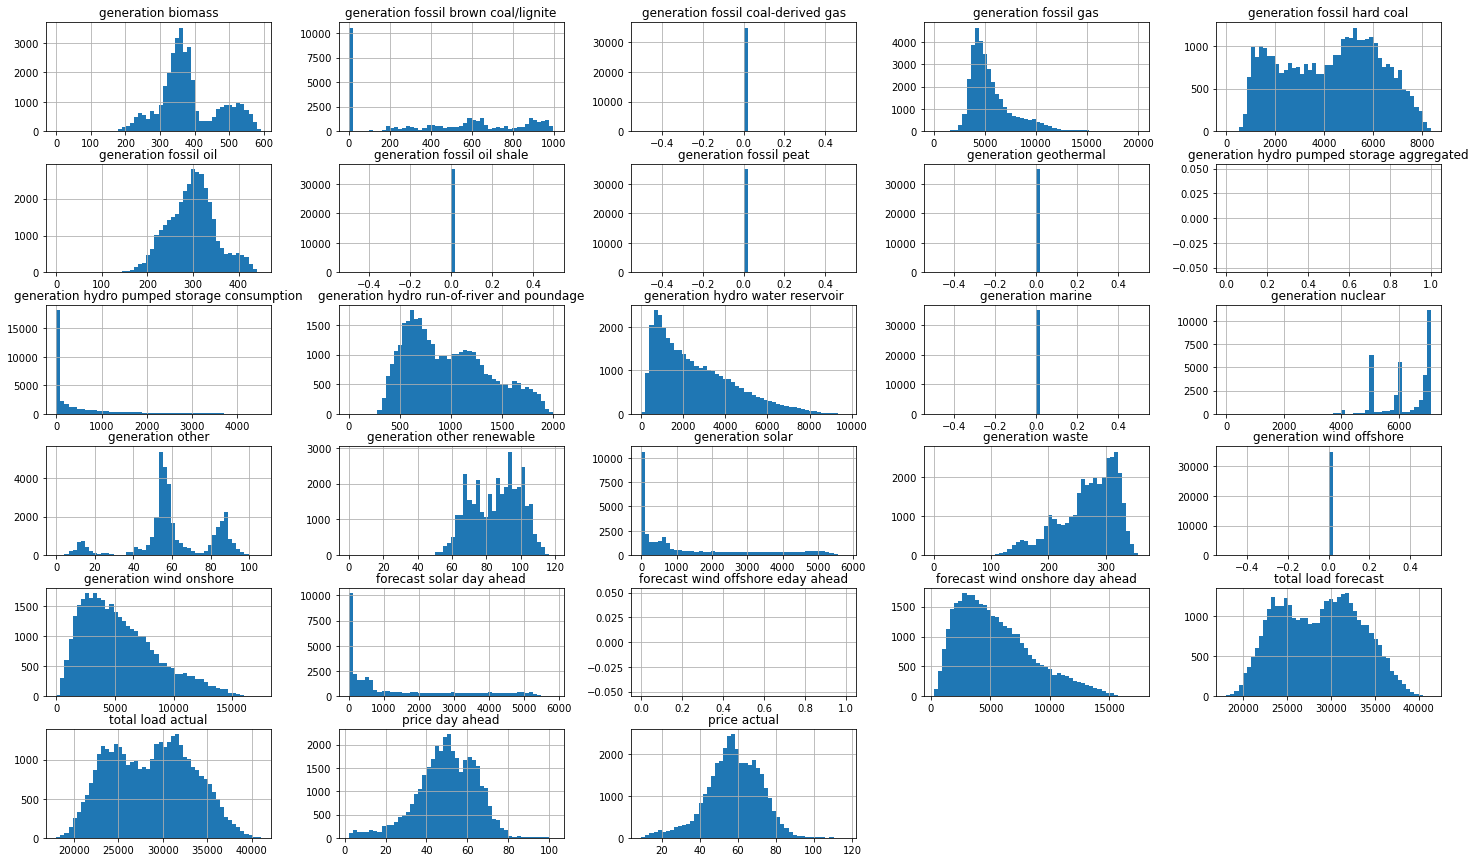

In [6]:
df_energy.hist(bins=50, figsize=(25, 15))
plt.show()


## Data Preparation and Cleaning


### Dataframe cleaning


- Columns with no actual data:
  - generation fossil coal-derived gas
  - generation fossil oil shale
  - generation fossil peat
  - generation geothermal
  - generation hydro pumped storage aggregated
  - generation marine
  - generation wind offshore
  - forecast wind offshore eday ahead
- The Count of values is different from the length of the DataFrame
- Therefore NaN-Values are in the Dataframe


In [7]:
# remove data with no values
df_energy = remove_columns(
    df_energy,
    [
        "generation fossil coal-derived gas",
        "generation fossil oil shale",
        "generation fossil peat",
        "generation geothermal",
        "generation hydro pumped storage aggregated",
        "generation marine",
        "generation wind offshore",
        "forecast wind offshore eday ahead",
    ],
)
# remove useless data
df_energy = remove_columns(
    df_energy,
    [
        "forecast solar day ahead",
        "forecast wind onshore day ahead",
        "total load forecast",
        "price day ahead",
    ],
)
# interpolate for missing data
df_energy.interpolate(inplace=True)
generation_parameters = [x for x in df_energy.columns if "generation" in x]
energy_parameters = [x for x in df_energy.columns if x not in generation_parameters]
df_energy.describe()


,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price actual
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,383.531343,448.094570,5622.700647,4256.531271,298.342417,475.582706,972.201902,2605.534123,6263.483430,60.226030,85.634326,1432.818546,269.418692,5464.980450,28698.281385,57.884023
std,85.346266,354.618269,2201.510984,1961.988937,52.519927,792.312704,400.712304,1835.175078,840.272333,20.238792,14.076948,1679.961733,50.218423,3213.586296,4575.828854,14.204083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18041.000000,9.330000
25%,333.000000,0.000000,4126.000000,2527.000000,263.000000,0.000000,637.000000,1078.000000,5759.000000,53.000000,73.000000,71.000000,240.000000,2933.000000,24807.000000,49.347500
50%,367.000000,509.000000,4969.500000,4475.000000,300.000000,68.000000,906.000000,2165.000000,6564.000000,57.000000,88.000000,616.000000,279.000000,4849.500000,28902.000000,58.020000
75%,433.000000,757.000000,6429.000000,5839.000000,330.000000,616.000000,1250.000000,3758.000000,7025.000000,80.000000,97.000000,2579.000000,310.000000,7399.500000,32194.250000,68.010000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,2000.000000,9728.000000,7117.000000,106.000000,119.000000,5792.000000,357.000000,17436.000000,41015.000000,116.800000


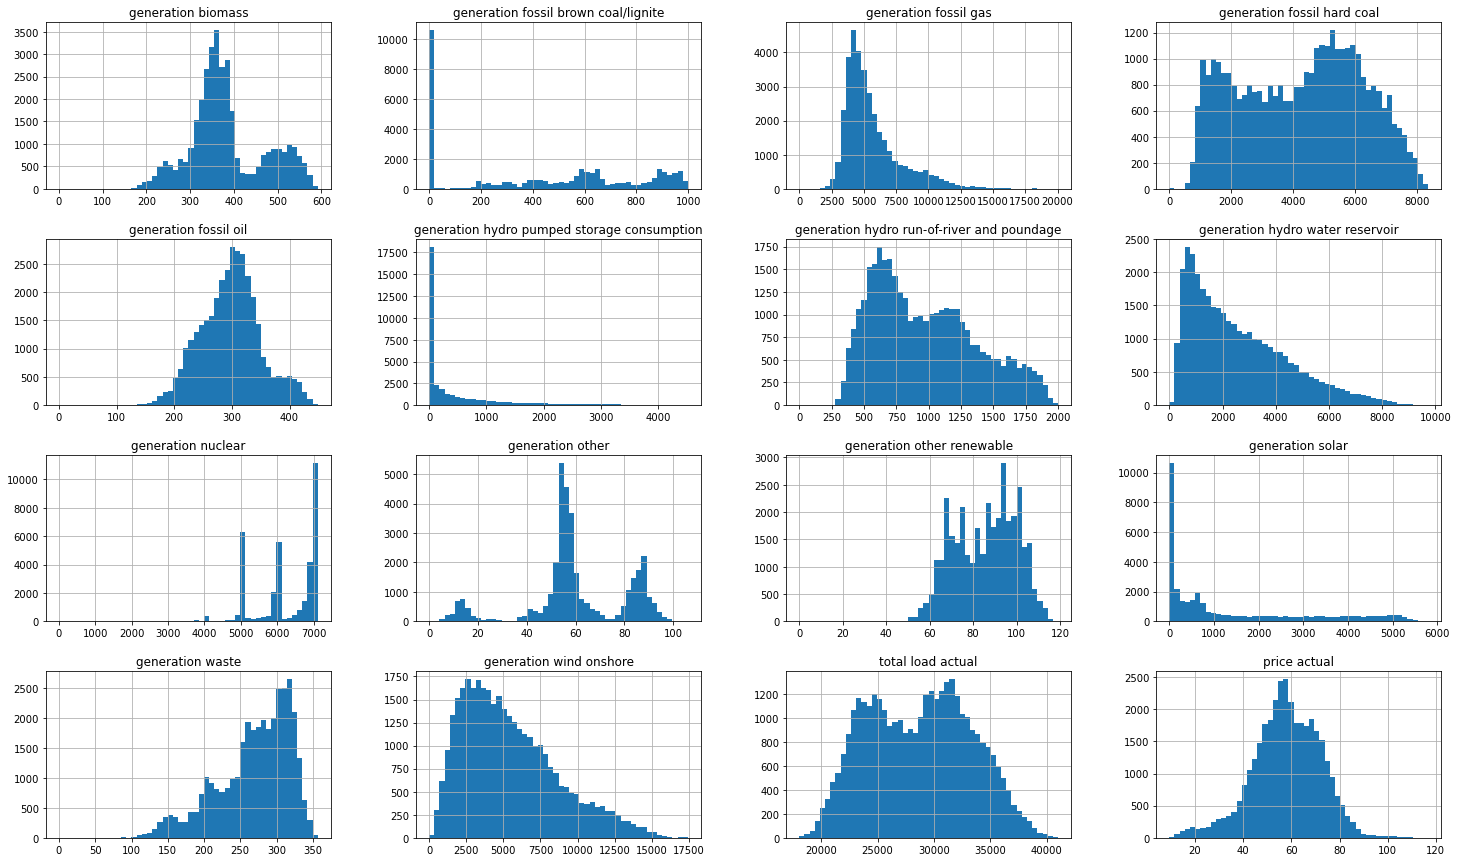

In [8]:
df_energy.hist(bins=50, figsize=(25, 15))
plt.show()


### Checking for overall length of the dataframe


In [9]:
date_period = pd.date_range(
    start="2015-01-01 00:00:00+1", end="2018-12-31 23:00:00+1", freq="H"
)
print("Length of the data frames: ", len(df_energy))
print("Length of the time periode: ", len(date_period))



Length of the data frames:  35064
Length of the time periode:  35064


## Checking energy mix

In [10]:
df_generation = average_over_year(df_energy)
df_generation = remove_columns(df_generation,["total load actual","price actual"])

In [11]:
months_list = ['January','February','March','April','May','June','July','August','September','October','November','December']
df_generation['month'] = months_list
df_generation.set_index('month',inplace=True)


In [12]:
fig= px.bar(df_generation)
fig.update_layout(barmode="relative")
fig.show()

In [13]:
df_generation['sum'] = df_generation.sum(axis=1)
for col in df_generation.columns:
    df_generation[col]= df_generation[col]/df_generation['sum']
df_generation = remove_columns(df_generation,["sum"])

In [14]:
fig= px.bar(df_generation)
fig.show()

# Analyzing weather dataset


In [15]:
df_weather = pd.read_csv("weather_features.csv")
df_weather


,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,287.760,287.150,288.150,1028,54,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178392,2018-12-31 20:00:00+01:00,Seville,285.760,285.150,286.150,1029,62,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178393,2018-12-31 21:00:00+01:00,Seville,285.150,285.150,285.150,1028,58,4,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178394,2018-12-31 22:00:00+01:00,Seville,284.150,284.150,284.150,1029,57,4,60,0.0,0.0,0.0,0,800,clear,sky is clear,01n


## General Analysis


In [16]:
df_weather.describe()


,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.000000,178396.000000,178396.000000,1.783960e+05,178396.000000,178396.00000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,289.618605,288.330442,291.091267,1.069261e+03,68.423457,2.47056,166.591190,0.075492,0.000380,0.004763,25.073292,759.831902
std,8.026199,7.955491,8.612454,5.969632e+03,21.902888,2.09591,116.611927,0.398847,0.007288,0.222604,30.774129,108.733223
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.670000,282.483602,284.650000,1.013000e+03,53.000000,1.00000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.00000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,295.150000,293.730125,297.150000,1.022000e+03,87.000000,4.00000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.00000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


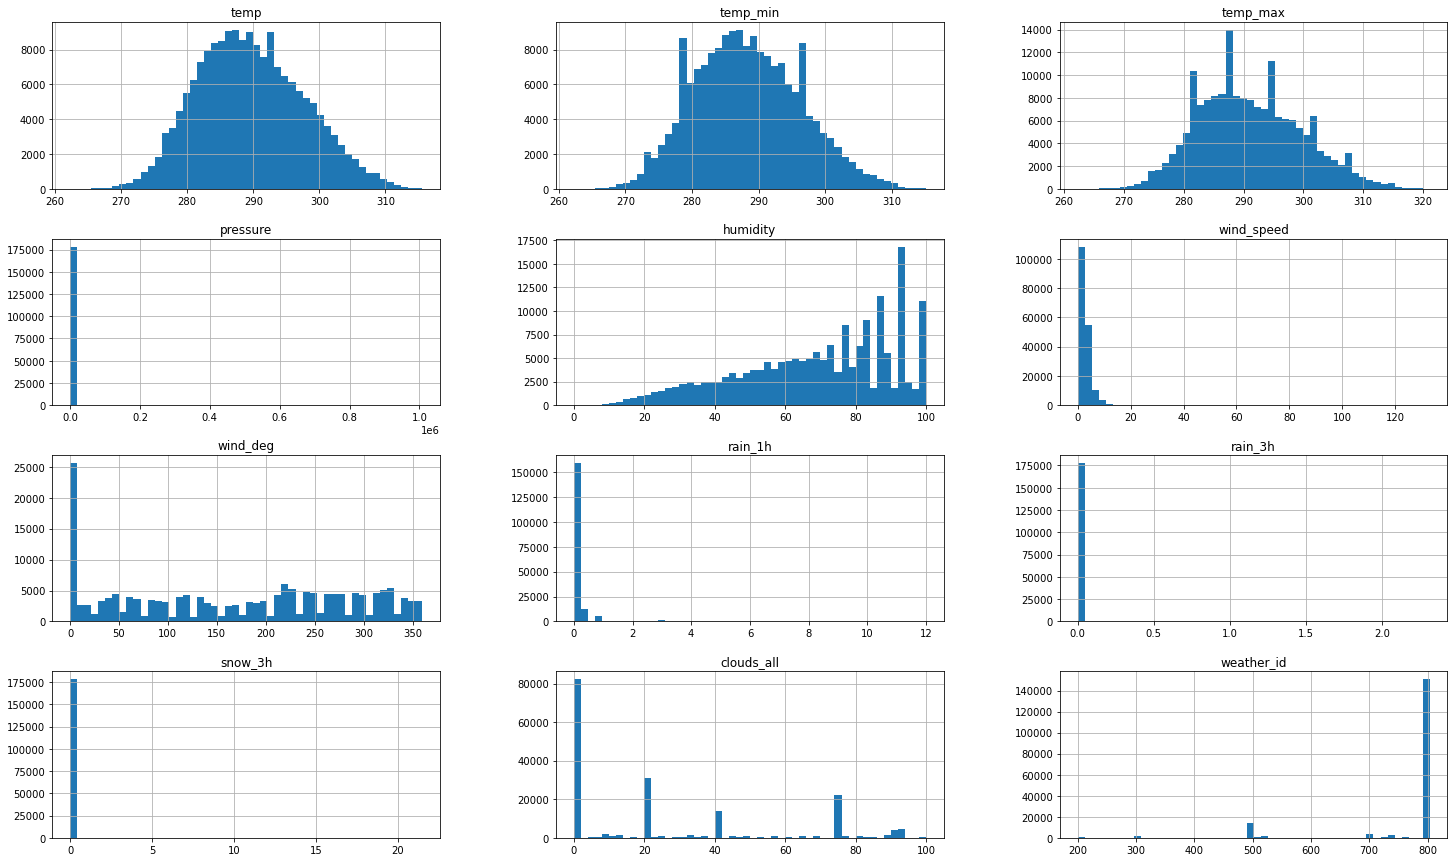

In [17]:
df_weather.hist(bins=50, figsize=(25, 15))
plt.show()


## Data Preparation and Analysis


### Outlier Handling


- Outliers in:
  - pressure
  - windspeed
- Removing Outliers by masking dataframe
- Data with no useful information:
  - temp_min
  - temp_max
  - rain_1h
  - rain_3h
  - snow_3h
  - clouds_all
  - weather_id
  - weather_main
  - weather_description
  - weather_icon


In [18]:
# Removing outliers with upper and lower treshhold
df_weather["pressure"].mask(df_weather["pressure"] >= 1.1e3, inplace=True)
df_weather["pressure"].mask(df_weather["pressure"] <= 0.9e3, inplace=True)
df_weather["wind_speed"].mask(df_weather["wind_speed"] >= 15, inplace=True)
# interpolating missing data
df_weather.interpolate(inplace=True)
# dropping columns with no useful data
df_weather = remove_columns(
    df_weather,
    [
        "temp_min",
        "temp_max",
        "rain_1h",
        "rain_3h",
        "snow_3h",
        "clouds_all",
        "weather_id",
        "weather_main",
        "weather_description",
        "weather_icon",
    ],
)
weather_parameters = [x for x in df_weather.columns]


In [19]:
df_weather.describe()


,temp,pressure,humidity,wind_speed,wind_deg
count,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,289.618605,1016.206927,68.423457,2.462953,166.591190
std,8.026199,12.448205,21.902888,2.024503,116.611927
min,262.240000,918.000000,0.000000,0.000000,0.000000
25%,283.670000,1013.000000,53.000000,1.000000,55.000000
50%,289.150000,1018.000000,72.000000,2.000000,177.000000
75%,295.150000,1022.000000,87.000000,4.000000,270.000000
max,315.600000,1090.000000,100.000000,14.000000,360.000000


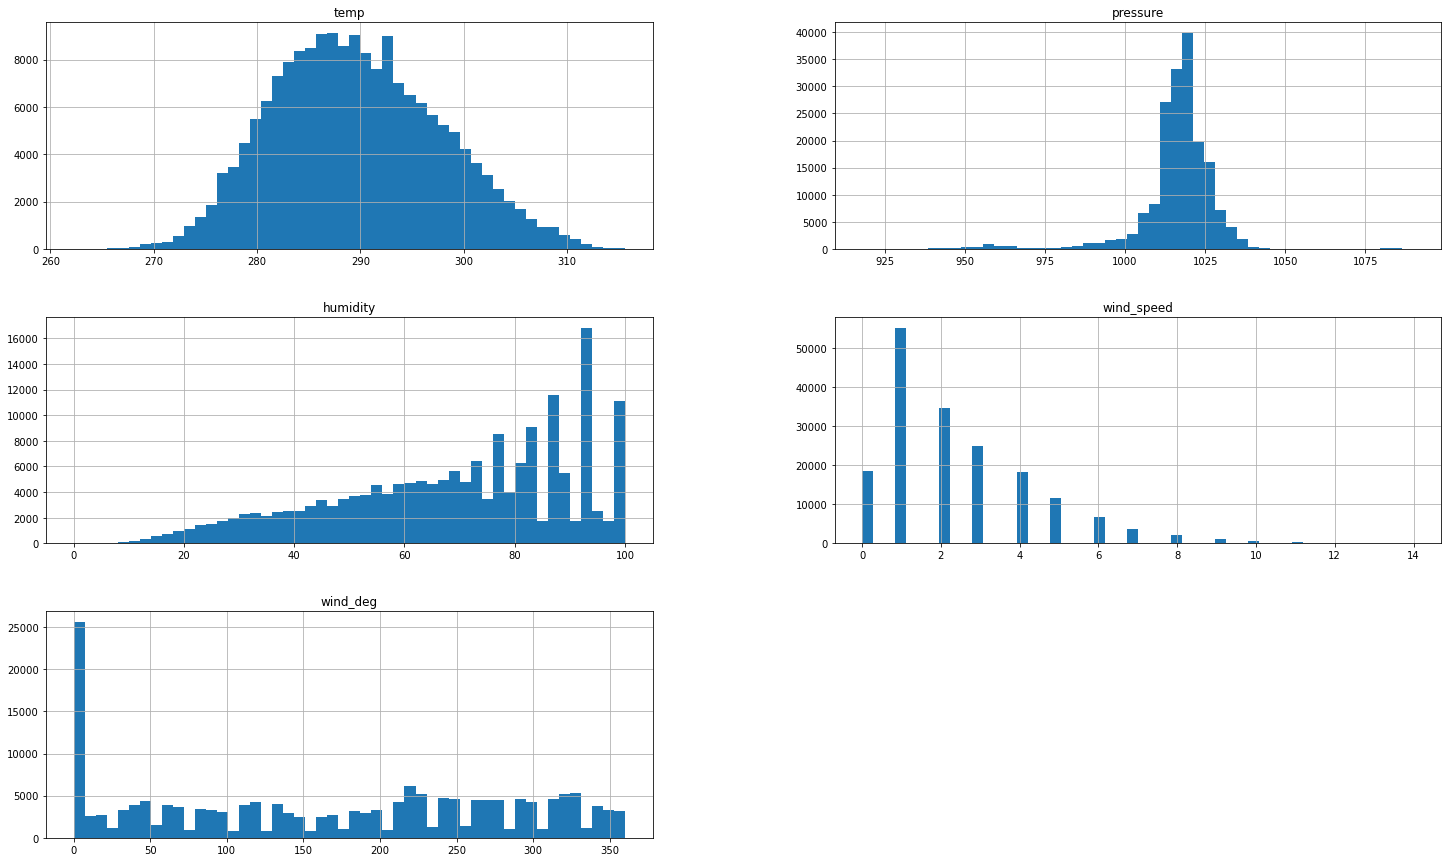

In [20]:
df_weather.hist(bins=50, figsize=(25, 15))
plt.show()


### Splitting into city data


In [21]:
city_list = ["Valencia", "Madrid", "Bilbao", "Barcelona", "Seville"]
df_weather["temp"] = df_weather["temp"].apply(lambda x: x - 273.15)
df_cities = [
    df_weather.query(f"city_name == '{x}'") for x in df_weather.city_name.unique()
]
for i, df in enumerate(df_cities):
    df_cities[i] = set_timestamp_index(df.copy(deep=True), "dt_iso")



In [22]:
for name, df in zip(city_list, df_cities):
    print(f"Length of the {name} DataFrame: ", len(df))



Length of the Valencia DataFrame:  35145
Length of the Madrid DataFrame:  36267
Length of the Bilbao DataFrame:  35951
Length of the Barcelona DataFrame:  35476
Length of the Seville DataFrame:  35557


### Cleaning timeseries


In [23]:
df_city_duplicates = display_double_timestamps()
df_valencia_duplicates = df_city_duplicates[0]
df_valencia_duplicates


,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
2015-01-06 04:00:00+01:00,Valencia,273.142,273.142,273.142,995,86,1,265,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-06 04:00:00+01:00,Valencia,273.142,273.142,273.142,995,86,1,265,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-06-15 21:00:00+02:00,Valencia,289.610,288.650,290.930,1018,100,3,330,0.9,0.0,0.0,75,501,rain,moderate rain,10d
2015-06-15 21:00:00+02:00,Valencia,289.610,288.650,290.930,1018,100,3,330,0.9,0.0,0.0,75,200,thunderstorm,thunderstorm with light rain,11d
2015-06-15 22:00:00+02:00,Valencia,289.240,288.150,290.370,1018,100,2,300,0.9,0.0,0.0,75,501,rain,moderate rain,10n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-16 21:00:00+01:00,Valencia,290.150,290.150,290.150,1019,93,3,40,0.3,0.0,0.0,75,520,rain,light intensity shower rain,09n
2018-12-13 08:00:00+01:00,Valencia,285.140,284.150,286.150,1011,76,4,270,0.3,0.0,0.0,40,500,rain,light rain,10n
2018-12-13 08:00:00+01:00,Valencia,285.140,284.150,286.150,1011,76,4,270,0.3,0.0,0.0,40,701,mist,mist,50n
2018-12-13 09:00:00+01:00,Valencia,283.640,283.150,284.150,1010,93,2,270,0.3,0.0,0.0,40,500,rain,light rain,10d


As you can see in the DataFrame the difference mostly occours due to a slight weather change within the hour timestamp.


In [24]:
for i, item in enumerate(df_cities):
    df_cities[i] = remove_duplicates(item)

for name, df in zip(city_list, df_cities):
    print(f"Length of the {name} DataFrame: ", len(df))

df_valencia = df_cities[0]
df_madrid = df_cities[1]
df_bilbao = df_cities[2]
df_barcelona = df_cities[3]
df_seville = df_cities[4]


Length of the Valencia DataFrame:  35064
Length of the Madrid DataFrame:  35064
Length of the Bilbao DataFrame:  35064
Length of the Barcelona DataFrame:  35064
Length of the Seville DataFrame:  35064


# Feature Engineering


In [25]:
combined_df = pd.concat([df_valencia, df_energy], axis=1)
combined_df = remove_columns(combined_df, ["city_name"])



## General Feature Extension


In [26]:
combined_df["generation"] = combined_df[generation_parameters].sum(axis=1)
combined_df["energy_difference"] = (
    combined_df["generation"] - combined_df["total load actual"]
)


## Time Feature Extension


In [27]:
# month, day, holiday
combined_df["month"] = combined_df.index.month
combined_df["day"] = combined_df.index.day
combined_df["weekend"] = np.where(df.index.weekday <= 4, 0, 1)
combined_df


,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation solar,generation waste,generation wind onshore,total load actual,price actual,generation,energy_difference,month,day,weekend
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,49.0,196.0,6378.0,25385.0,65.41,28251.0,2866.0,1,1,0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,50.0,195.0,5890.0,24382.0,64.92,27818.0,3436.0,1,1,0
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,50.0,196.0,5461.0,22734.0,64.48,26796.0,4062.0,1,1,0
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,50.0,191.0,5238.0,21286.0,59.32,25223.0,3937.0,1,1,0
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,42.0,189.0,4935.0,20264.0,56.04,24620.0,4356.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,85.0,277.0,3113.0,30653.0,77.02,26415.0,-4238.0,12,31,0
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,33.0,280.0,3288.0,29735.0,76.16,25213.0,-4522.0,12,31,0
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,31.0,286.0,3503.0,28071.0,74.30,23987.0,-4084.0,12,31,0
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,31.0,287.0,3586.0,25801.0,69.89,22748.0,-3053.0,12,31,0


## Data Scaling


In [28]:
# Rescaling the data
featuresToScale = combined_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df = combined_df.copy(deep=True)
scaled_df.loc[:, featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])
scaled_df.sort_index(inplace=True)
scaled_df.describe()


,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation solar,generation waste,generation wind onshore,total load actual,price actual,generation,energy_difference,month,day,weekend
count,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,...,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04
mean,3.015308e-16,6.111673e-16,2.982885e-16,5.187627e-17,-1.134793e-16,2.658659e-16,-1.167216e-16,-2.010205e-16,8.754120e-17,-3.177421e-16,...,-6.484533e-17,-1.296907e-16,-7.781440e-17,-2.289851e-16,2.010205e-16,-1.617080e-16,4.052833e-18,-3.890720e-17,9.645743e-17,4.863400e-18
std,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,...,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00
min,-3.034543e+00,-3.935452e+00,-2.901411e+00,-1.161697e+00,-1.335441e+00,-4.493891e+00,-1.263615e+00,-2.554055e+00,-2.169529e+00,-5.680638e+00,...,-8.528998e-01,-5.365014e+00,-1.700610e+00,-2.329072e+00,-3.418363e+00,-5.193211e+00,-1.146634e+01,-1.601685e+00,-1.673784e+00,-6.330616e-01
25%,-7.787656e-01,-3.333518e-01,-7.162298e-01,-7.242735e-01,-9.201962e-01,-5.920829e-01,-1.263615e+00,-6.798612e-01,-8.815320e-01,-6.729431e-01,...,-8.106363e-01,-5.858231e-01,-7.879099e-01,-8.504114e-01,-6.009993e-01,-7.622765e-01,-7.005958e-01,-7.317916e-01,-8.783552e-01,-6.330616e-01
50%,-8.210053e-02,8.549706e-02,9.686091e-02,-2.868501e-01,-2.558045e-01,-1.937001e-01,1.717517e-01,-2.967098e-01,1.113522e-01,3.156149e-02,...,-4.862195e-01,1.907954e-01,-1.915272e-01,4.452123e-02,9.573234e-03,-4.373375e-02,-1.482682e-01,1.381020e-01,3.070583e-02,-6.330616e-01
75%,7.417336e-01,4.205762e-01,8.591335e-01,5.879966e-01,9.899300e-01,5.796313e-01,8.711052e-01,3.662534e-01,8.065750e-01,6.027814e-01,...,6.822761e-01,8.081076e-01,6.019901e-01,7.640186e-01,7.129021e-01,7.003689e-01,5.128981e-01,1.007996e+00,8.261342e-01,1.579625e+00
max,2.815142e+00,5.949381e+00,1.773861e+00,4.962230e+00,1.654322e+00,2.442657e+00,1.553539e+00,6.546188e+00,2.091004e+00,2.868620e+00,...,2.594847e+00,1.744032e+00,3.725181e+00,2.691730e+00,4.147879e+00,3.265672e+00,4.487255e+00,1.587925e+00,1.735195e+00,1.579625e+00


## Correlation Matrix


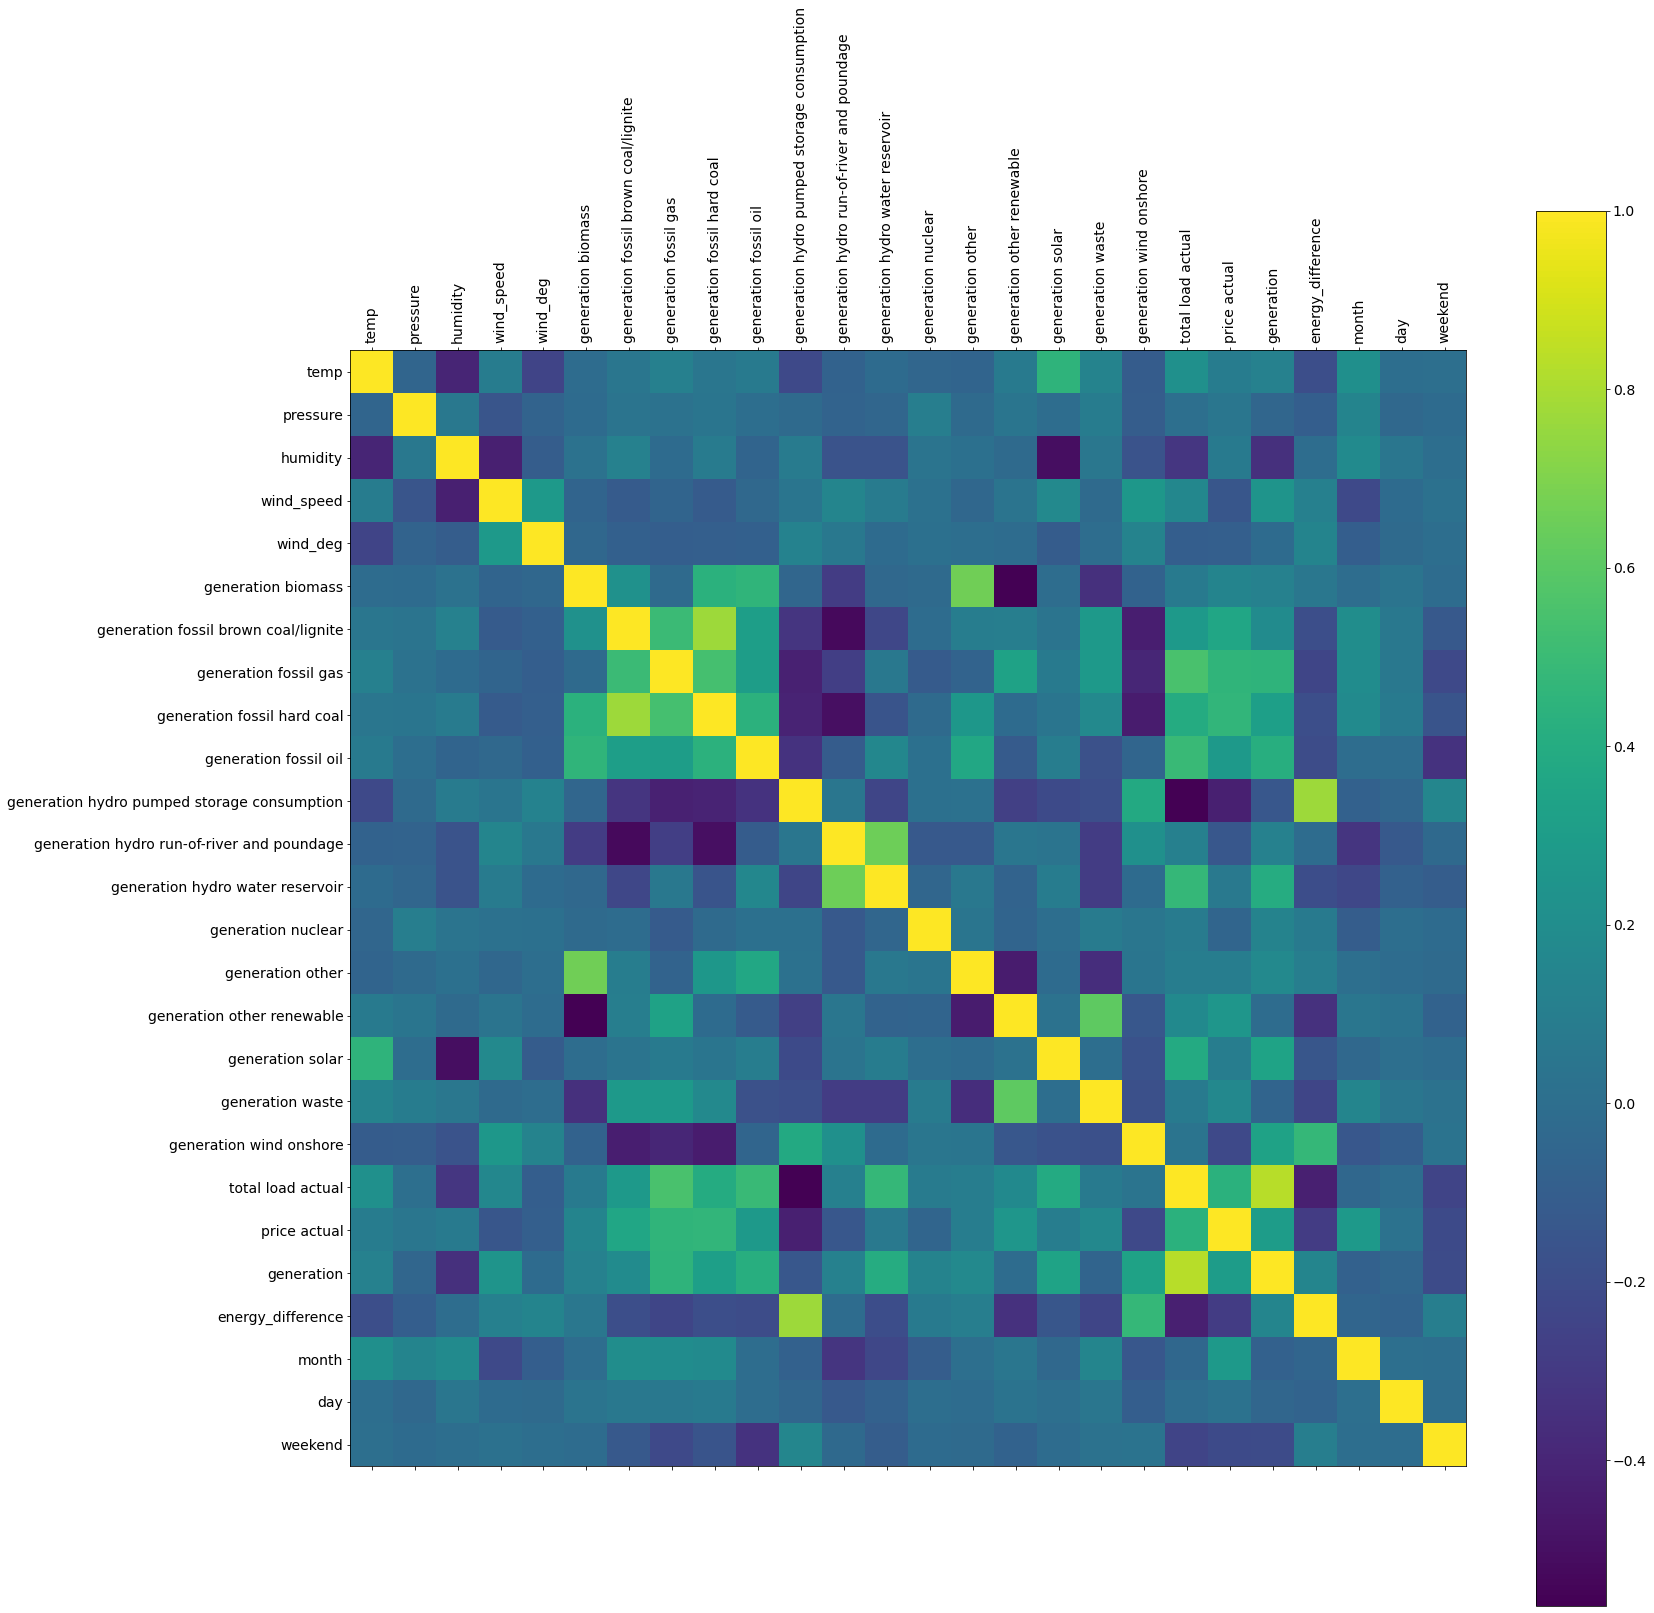

In [29]:
correlationMatrix = pd.DataFrame(scaled_df).corr()
f = plt.figure(figsize=(25, 25))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(scaled_df.shape[1]), scaled_df.columns, fontsize=14, rotation=90)
plt.yticks(range(scaled_df.shape[1]), scaled_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()


In [30]:
# Extract high correlation pairs with upper and lower treshhold
correlations = extract_correlations(correlationMatrix, 0.5, -0.4)
for item in correlations:
    print(item)


('generation hydro pumped storage consumption', 'total load actual', -0.5629342077948891)
('generation biomass', 'generation other renewable', -0.5605666986824334)
('generation fossil brown coal/lignite', 'generation hydro run-of-river and poundage', -0.5247213973083811)
('humidity', 'generation solar', -0.5047695097546638)
('generation fossil hard coal', 'generation hydro run-of-river and poundage', -0.4975783169794325)
('generation other', 'generation other renewable', -0.44345430163624594)
('generation fossil hard coal', 'generation wind onshore', -0.4417562740188647)
('generation fossil brown coal/lignite', 'generation wind onshore', -0.434172302338624)
('total load actual', 'energy_difference', -0.4265643564076236)
('humidity', 'wind_speed', -0.4263445615968573)
('generation hydro pumped storage consumption', 'price actual', -0.42619560242913923)
('generation fossil gas', 'generation hydro pumped storage consumption', -0.4207520079278396)
('generation fossil hard coal', 'generatio

## PCA Analysis


In [31]:
n_components = None
whiten = False
svd_solver = "auto"
random_state = 2020

pca = PCA(
    n_components=n_components,
    whiten=whiten,
    svd_solver=svd_solver,
    random_state=random_state,
)
x_pca = pca.fit(scaled_df)


Text(0, 0.5, 'cumulative explained variance')

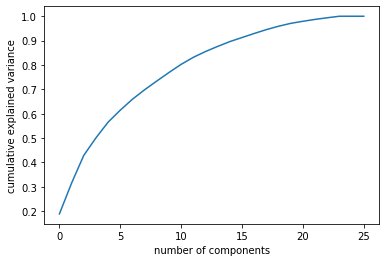

In [32]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")


In [33]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(scaled_df)  # this will fit and reduce dimensions
print(
    pca.n_components_
)  # one can print and see how many components are selected. In this case it is 4 same as above we saw in step 5


19


In [34]:
pd.DataFrame(pca.components_, columns=scaled_df.columns)


,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation solar,generation waste,generation wind onshore,total load actual,price actual,generation,energy_difference,month,day,weekend
0,-0.129891,-0.034692,0.037501,0.043391,0.092407,-0.109197,-0.309731,-0.337886,-0.348331,-0.257588,...,-0.136203,-0.124399,0.209294,-0.333061,-0.297654,-0.213466,0.244165,-0.105579,-0.037446,0.137048
1,0.082167,-0.097318,-0.322151,0.253435,0.054915,0.058220,-0.191368,-0.041307,-0.117293,0.162759,...,0.213997,-0.246102,0.245612,0.309592,-0.031865,0.370998,0.052857,-0.221286,-0.076144,-0.078758
2,0.136422,0.014764,-0.132476,0.095570,-0.002007,-0.474636,-0.122909,0.076058,-0.213176,-0.231788,...,0.123745,0.302517,-0.046978,0.084913,0.004022,-0.042088,-0.218736,-0.026941,-0.009546,0.015525
3,0.259807,-0.071369,-0.325590,0.321474,0.117263,-0.014562,0.145195,0.051524,0.094549,-0.088079,...,0.240566,0.221768,0.201603,-0.006756,-0.075757,0.194219,0.326890,0.094451,0.030271,0.115294
4,0.467364,0.002712,-0.235875,-0.071883,-0.279008,0.159873,-0.095859,-0.205589,-0.076772,-0.054406,...,0.389005,-0.150069,-0.270516,-0.117086,-0.129462,-0.271751,-0.233116,0.089360,0.042268,0.231084
5,0.197188,0.334137,0.108848,-0.350053,-0.454364,-0.119766,-0.128225,0.030846,-0.127258,0.006471,...,0.038884,-0.023972,0.244157,0.074873,0.156157,0.212266,0.211480,0.413016,-0.238221,-0.085757
6,0.093896,-0.429390,-0.004803,0.018679,0.031073,-0.019076,0.012797,0.190123,0.023537,-0.029426,...,-0.083495,-0.130266,0.050543,-0.084799,0.166308,0.003213,0.155501,0.275048,-0.022318,-0.039639
7,0.037515,-0.373028,0.125443,-0.151533,-0.432017,-0.059303,-0.020612,0.056382,-0.028135,0.002300,...,0.005854,-0.010104,0.061876,0.043516,-0.066535,0.110209,0.101574,-0.186208,0.720528,-0.065219
8,-0.138905,-0.165550,0.098651,-0.079662,-0.219812,-0.012782,0.176474,0.152897,0.151581,-0.241212,...,0.006756,0.054389,-0.129734,0.086021,-0.039971,0.175528,0.132152,-0.190690,-0.289054,0.712387
9,-0.104099,0.424308,-0.015174,0.069400,0.281400,0.047196,-0.109352,0.036985,-0.019620,-0.173771,...,0.005938,-0.037721,0.050166,0.085948,0.185404,0.087798,-0.009967,0.319378,0.557398,0.405409


In [35]:
n_pcs = pca.n_components_
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = scaled_df.columns
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
print("Most important components:")
for item in most_important_names:
    print(item)
print("")
print("Least important components:")
for item in scaled_df.columns:
    if item not in most_important_names:
        print(item)


Most important components:
generation fossil hard coal
generation
generation biomass
generation hydro water reservoir
temp
wind_deg
generation nuclear
day
weekend
day
pressure
generation nuclear
price actual
wind_speed
generation other
generation fossil gas
generation solar
generation fossil oil
humidity

Least important components:
generation fossil brown coal/lignite
generation hydro pumped storage consumption
generation hydro run-of-river and poundage
generation other renewable
generation waste
generation wind onshore
total load actual
energy_difference
month


## Decomposition


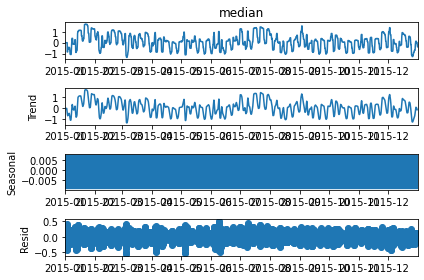

In [36]:
fig = display_seasonal_decomposition(
    scaled_df["2015-01-01 00:00:00":"2015-12-31 23:00:00"],
    "total load actual",
    48,
    "median",
)


## Autocorrelation and Partial Autocorrelation


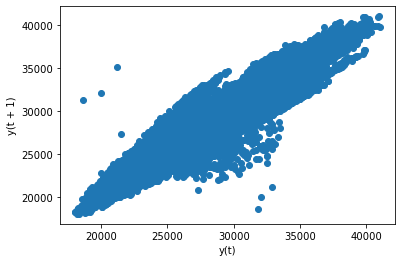

In [37]:
plt.figure()
lag_plot(combined_df["total load actual"])
mpl.rcParams["figure.figsize"] = [8.0, 8.0]


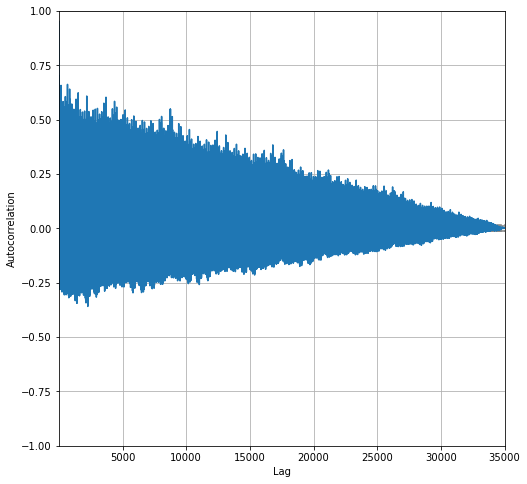

In [38]:
# Checking autocorrelations:
plt.figure()
autocorrelation_plot(combined_df["total load actual"])
mpl.rcParams["figure.figsize"] = [8.0, 8.0]


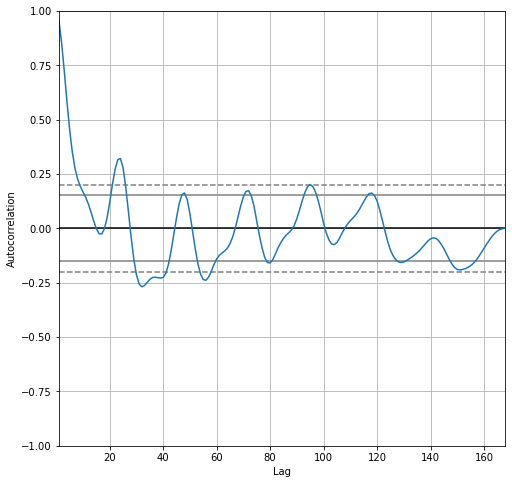

In [39]:
# Checking autocorrelations:
plt.figure()
subset = combined_df["total load actual"]["2015-01-01":"2015-01-07"]
autocorrelation_plot(subset)
mpl.rcParams["figure.figsize"] = [8.0, 8.0]


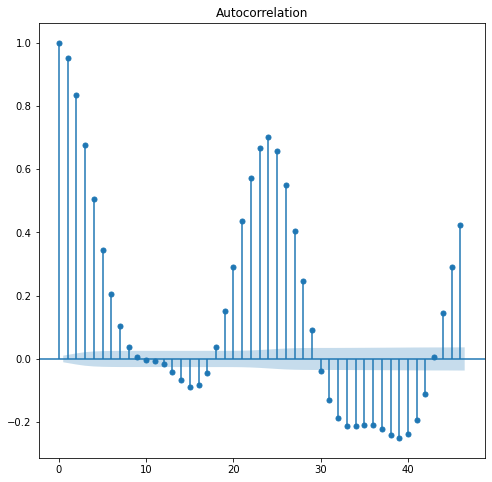

<Figure size 576x576 with 0 Axes>

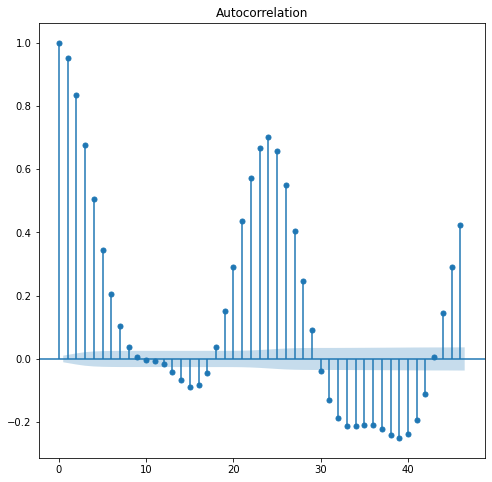

In [40]:
plt.figure()
plot_acf(combined_df["total load actual"])


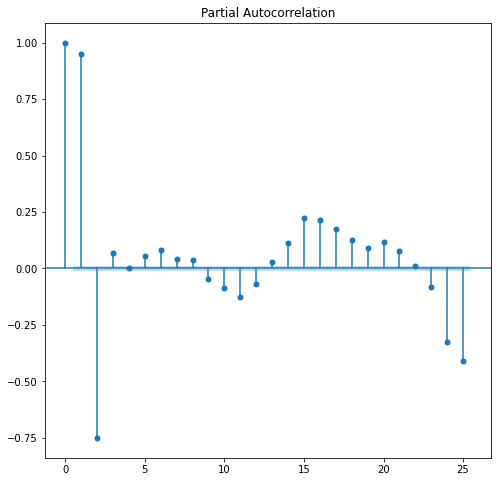

In [41]:
plot_pacf(combined_df["total load actual"], lags=25)
mpl.rcParams["figure.figsize"] = [12.0, 6.0]


# Baseline Models


In [42]:
combined_df


,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation solar,generation waste,generation wind onshore,total load actual,price actual,generation,energy_difference,month,day,weekend
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,49.0,196.0,6378.0,25385.0,65.41,28251.0,2866.0,1,1,0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,50.0,195.0,5890.0,24382.0,64.92,27818.0,3436.0,1,1,0
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,50.0,196.0,5461.0,22734.0,64.48,26796.0,4062.0,1,1,0
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,50.0,191.0,5238.0,21286.0,59.32,25223.0,3937.0,1,1,0
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,42.0,189.0,4935.0,20264.0,56.04,24620.0,4356.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,85.0,277.0,3113.0,30653.0,77.02,26415.0,-4238.0,12,31,0
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,33.0,280.0,3288.0,29735.0,76.16,25213.0,-4522.0,12,31,0
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,31.0,286.0,3503.0,28071.0,74.30,23987.0,-4084.0,12,31,0
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,31.0,287.0,3586.0,25801.0,69.89,22748.0,-3053.0,12,31,0


## SARIMAX


In [43]:
%%skip $SKIP_SARIMAX
#Warning update:
#----------------
#each optimization inside the profile likelihood generates a warning, 
#we turn off the warnings here to make the output clean in the below cell:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
#You can check the source code from here:
#https://www.statsmodels.org/0.8.0/_modules/statsmodels/base/model.html

### Singlestep prediction


Creating test-train-split datasets


In [44]:
%%skip $SKIP_SARIMAX
train_start = "2015-01-01"
test_start = "2017-01-01"
test_end = "2017-01-02"
combined_df.index.freq = "h"

data_y_train,data_y_test,data_exog_train,data_exog_test = create_sarimax_test_train_split(combined_df,'total load actual','temp',train_start=train_start,test_start=test_start,test_end=test_end,)


Scaling dataset with MinMaxScaler


In [45]:
%%skip $SKIP_SARIMAX
scaler_1 = pp.MinMaxScaler()
scaler_2 = pp.MinMaxScaler()
data_y_train['total load actual'] = scaler_1.fit_transform(data_y_train)
data_y_test['total load actual'] = scaler_1.transform(data_y_test)

data_exog_train['temp'] = scaler_2.fit_transform(data_exog_train)
data_exog_test['temp'] = scaler_2.transform(data_exog_test)

Hyperparameter setttings for SARIMAX

In [46]:
%%skip $SKIP_SARIMAX
#-----------------------------------------------------------
#Hyperparameters
#-----------------------------------------------------------
horizon = 1
order = (3, 2, 8)
seasonal_order = (1, 1, 1, 24)
exog = data_exog_train

Preparing data for SARIMAX


In [47]:
%%skip $SKIP_SARIMAX
test_ts, history, predictions, history_temp, predictions_temp = prepare_data_sarimax(
    data_y_train = data_y_train,
    data_y_test = data_y_test,
    exog_y_train = data_exog_train,
    exog_y_test = data_exog_test,
    horizon = horizon,
    training_window=720,
    feature="total load actual",
    exog_feature="temp",
)

Model Predictions


In [48]:
%%skip $SKIP_SARIMAX
# Calling model:
# Horizon calculation list:
for t in range(0, test_ts.shape[0], horizon):

    # Model handling
    model = SARIMAX(
        endog=history, exog=history_temp, order=order, seasonal_order=seasonal_order
    )
    model_fit = model.fit()
    y_p = model_fit.forecast(
        steps=horizon, exog=predictions_temp.iloc[:horizon].to_frame()
    ).tolist()

    # Observation and predictions
    obs = list(test_ts.iloc[t])
    predictions.extend(y_p)

    # handling history data
    history = history.append(
        pd.Series(
            y_p,
            index=pd.date_range(
                start=history.index[-1] + timedelta(hours=1), periods=horizon, freq="h"
            ),
        )
    )
    history = history[horizon:]

    # handling exog history data
    history_temp = history_temp.append(predictions_temp.iloc[:horizon])
    history_temp.drop(index=history_temp.index[:horizon], inplace=True)
    predictions_temp.drop(index=predictions_temp.index[:horizon], inplace=True)

    print(test_ts.index[t])
    print(t + 1, ": predicted =", y_p, "true value =", obs)



Create eval_df


In [49]:
%%skip $SKIP_SARIMAX
# Evaluation of results:
# We will combine the predictions with the actual load values in a DF. 
eval_df = pd.DataFrame(predictions)
eval_df.columns = ['prediction']
# Updating the indices:
eval_df=(eval_df.set_index(data_y_test.index)) 
# true values:
eval_df['actual'] = data_y_test
#Back-transforming:
eval_df[['prediction', 'actual']] = scaler_1.inverse_transform(eval_df[['prediction', 'actual']])

In [50]:
%%skip $SKIP_SARIMAX
plot_predictions(eval_df,horizon,'prediction','actual','SARIMAX','Load')

In [51]:
%%skip $SKIP_SARIMAX
plot_accuracy(eval_df,'actual','prediction','Load')

In [52]:
%%skip $SKIP_SARIMAX
plot_error_variations(eval_df,'actual','prediction')

In [53]:
%%skip $SKIP_SARIMAX
#Calculating R^2: r2_score(y_true, y_pred)
Score_sarimax = r2_score(eval_df['actual'],eval_df['prediction'])
print('R^2 score is  %3.2f' %np.mean(Score_sarimax))

### Multistep Prediction


Creating test-train-split datasets


In [54]:
%%skip $SKIP_SARIMAX
train_start = "2015-01-01"
test_start = "2017-01-01"
test_end = "2017-01-02"
combined_df.index.freq = "h"

data_y_train,data_y_test,data_exog_train,data_exog_test = create_sarimax_test_train_split(combined_df,'total load actual','temp',train_start=train_start,test_start=test_start,test_end=test_end,)


Scaling dataset with MinMaxScaler


In [55]:
%%skip $SKIP_SARIMAX
scaler_1 = pp.MinMaxScaler()
scaler_2 = pp.MinMaxScaler()
data_y_train['total load actual'] = scaler_1.fit_transform(data_y_train)
data_y_test['total load actual'] = scaler_1.transform(data_y_test)

data_exog_train['temp'] = scaler_2.fit_transform(data_exog_train)
data_exog_test['temp'] = scaler_2.transform(data_exog_test)

Hyperparameter setttings for SARIMAX


In [56]:
%%skip $SKIP_SARIMAX
#-----------------------------------------------------------
#Hyperparameters
#-----------------------------------------------------------
horizon = 6
order = (3, 2, 8)
seasonal_order = (1, 1, 1, 24)
exog = data_exog_train

Preparing data for SARIMAX


In [57]:
%%skip $SKIP_SARIMAX
test_ts, history, predictions, history_temp, predictions_temp = prepare_data_sarimax(
    data_y_train = data_y_train,
    data_y_test = data_y_test,
    exog_y_train = data_exog_train,
    exog_y_test = data_exog_test,
    horizon = horizon,
    training_window=720,
    feature="total load actual",
    exog_feature="temp",
)

Model Predictions


In [58]:
%%skip $SKIP_SARIMAX
# Calling model:
# Horizon calculation list:
for t in range(0, test_ts.shape[0], horizon):

    # Model handling
    model = SARIMAX(
        endog=history, exog=history_temp, order=order, seasonal_order=seasonal_order
    )
    model_fit = model.fit()
    y_p = model_fit.forecast(
        steps=horizon, exog=predictions_temp.iloc[:horizon].to_frame()
    ).tolist()

    # Observation and predictions
    obs = list(test_ts.iloc[t])
    predictions.extend(y_p)

    # handling history data
    history = history.append(
        pd.Series(
            y_p,
            index=pd.date_range(
                start=history.index[-1] + timedelta(hours=1), periods=horizon, freq="h"
            ),
        )
    )
    history = history[horizon:]

    # handling exog history data
    history_temp = history_temp.append(predictions_temp.iloc[:horizon])
    history_temp.drop(index=history_temp.index[:horizon], inplace=True)
    predictions_temp.drop(index=predictions_temp.index[:horizon], inplace=True)

    print(test_ts.index[t])
    print(t + 1, ": predicted =", y_p, "true value =", obs)



Create eval_df


In [59]:
%%skip $SKIP_SARIMAX
# Evaluation of results:
# We will combine the predictions with the actual load values in a DF. 
eval_df = pd.DataFrame(predictions)
eval_df.columns = ['prediction']
# Updating the indices:
eval_df=(eval_df.set_index(data_y_test.index)) 
# true values:
eval_df['actual'] = data_y_test['total load actual']
#Back-transforming:
eval_df[['prediction', 'actual']] = scaler_1.inverse_transform(eval_df[['prediction', 'actual']])

In [60]:
%%skip $SKIP_SARIMAX
plot_predictions(eval_df,horizon,'prediction','actual','SARIMAX','Load')

In [61]:
%%skip $SKIP_SARIMAX
plot_accuracy(eval_df,'actual','prediction','Load')

In [62]:
%%skip $SKIP_SARIMAX
plot_error_variations(eval_df,'actual','prediction')

In [63]:
%%skip $SKIP_SARIMAX
#Calculating R^2: r2_score(y_true, y_pred)
Score_sarimax = r2_score(eval_df['actual'],eval_df['prediction'])
print('R^2 score is  %3.2f' %np.mean(Score_sarimax))

## SVM


### Singlestep prediction


Loading the data set

In [64]:
%%skip $SKIP_SVM
scaled_df = combined_df.copy(deep=True)

Scaling the data set

In [65]:
%%skip $SKIP_SVM
#Rescaling the data
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Creating Test-Train split

In [66]:
%%skip $SKIP_SVM
# Train-Test Split
# We will split the data as training and test. No need for validation here. 
train_start = '2015-01-01'
test_start = '2017-01-01'
test_end = '2017-01-04'
scaled_df.index.freq = 'h' 
feature_df = combined_df['total load actual']
(
    data_x_train,
    data_x_test,
    data_y_train,
    data_y_test,

) = create_test_train_split(
    df_x=scaled_df,df_y=feature_df,train_start=train_start,test_start=test_start,test_end=test_end,)


Hyperparameters

In [67]:
%%skip $SKIP_SVM
# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)
 

Fitting the model to the training data

In [68]:
%%skip $SKIP_SVM
# Model Training:
model = svr
#Fitting the model according to given data:
model.fit(data_x_train, data_y_train)

Getting model prediction scores

In [69]:
%%skip $SKIP_SVM
#Model Predictions:
#------------------
scoreTraining = model.score(data_x_train, data_y_train)
print('-----------------------------------')
print('SVM Regression Training R^2 Score: ', scoreTraining)
print('-----------------------------------')
scoreValidation = model.score(data_x_test, data_y_test)
print('-----------------------------------')
print('SVM Regression Validation R^2 Score: ', scoreValidation)
print('-----------------------------------')

Model predictions

In [70]:
%%skip $SKIP_SVM
#Visual Comparisons
#------------------
# Let's get the predictions first:
y_predict = pd.Series(svr.predict(data_x_test),index=data_y_test.index)

In [71]:
%%skip $SKIP_SVM
#Plotting the Figure:
plt.figure();
plt.plot(data_y_test, 'k.-');
plt.plot(y_predict, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead for 72 hours'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SVM');

### Multistep prediction


Loading the data set

In [72]:
%%skip $SKIP_SVM
scaled_df = combined_df.copy(deep=True)

Scaling the data set

In [73]:
%%skip $SKIP_SVM
#Rescaling the data
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Creating Test-Train split

In [74]:
%%skip $SKIP_SVM
# Train-Test Split
# We will split the data as training and test. No need for validation here. 
train_start = '2015-01-01'
test_start = '2017-01-01'
test_end = '2017-01-04'
scaled_df.index.freq = 'h' 
feature_df = combined_df['total load actual']
(
    data_x_train,
    data_x_test,
    data_y_train,
    data_y_test,

) = create_test_train_split(
    df_x=scaled_df,df_y=feature_df,train_start=train_start,test_start=test_start,test_end=test_end,)


Hyperparameters

In [75]:
%%skip $SKIP_SVM

pd.options.mode.chained_assignment = None  # default='warn'

# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)
 

Fitting the model to the training data

In [76]:
%%skip $SKIP_SVM
# Model Training:
model = svr
#Fitting the model according to given data:
model.fit(data_x_train, data_y_train)

In [77]:
%%skip $SKIP_SVM
y_predicted =pd.Series(index=data_y_test.index)

Model predictions

In [78]:
%%skip $SKIP_SVM
case_indices = data_y_test.index
window = 720
start_case_index = case_indices[0]-timedelta(hours=window)
end_case_index = case_indices[0]-timedelta(hours=1)
data_x_last = scaled_df[start_case_index:end_case_index]
dummy_array = np.zeros((1,data_x_last.shape[1])) 

for case_index in case_indices:
  # Predicting with fitted SVM(x_test_last)
  load_prediction = svr.predict(data_x_last).flatten()[0]
  # Preparing the next X_test_last:
  y_predicted.update(pd.Series(load_prediction,index=[case_index]))
  # scaling the load
  dummy_array[0,data_x_last.shape[1]-1] = load_prediction
  load_scaled = sX.transform(dummy_array)[0,data_x_last.shape[1]-1]
  
  start_case_index = case_index-timedelta(hours=window-1)
  end_case_index=case_index

  data_x_last = scaled_df[start_case_index:end_case_index]
  #data_x_last['total load actual'] = data_x_last['total load actual'].replace(case_index,load_scaled)
  data_x_last.loc[case_index,'total load actual'] = load_scaled


In [79]:
%%skip $SKIP_SVM
#Plotting the Figure:
plt.figure();
plt.plot(data_y_test, 'k.-');
plt.plot(y_predicted, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead for 72 hours'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SVM');

# Advanced Models

## Simple NN


Scale the input data

In [80]:
#Rescaling the data
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [81]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-06'
feature = 'total load actual'
feature_df = combined_df[feature]
data_x_train,data_x_val,data_x_test,data_y_train,data_y_val,data_y_test = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)


Define the Model

In [82]:
def build_model_batch():
  #Here we will use Sequential API
  model = models.Sequential([
  layers.Dense(32, kernel_initializer="he_normal", input_shape=(data_x_train.shape[1],)),keras.layers.LeakyReLU(alpha=0.1),                           
  layers.BatchNormalization(),
  layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal"),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(1)
  ])
  
  model.compile(optimizer='Adam', loss=['mse'], metrics=['mae'])
  return model


In [83]:
build_model_batch().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                864       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

Define Callback functions

In [84]:
#We will first create the object to feed fit() method:
myCheckpoint= keras.callbacks.ModelCheckpoint("my_best_NN_model.h5", save_best_only=True)
myEarly_stopping = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

Hyperparameters

In [85]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 1000
batch_size = 10

Training the model

In [86]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
%%skip $SKIP_RETRAIN_NN
model_base = build_model_batch()
history_base = model_base.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                callbacks=[myCheckpoint,myEarly_stopping])#, verbose=0)
#Calling back the best model:


UsageError: Line magic function `%%skip` not found.


Evaluate the training process

In [87]:
%%skip $SKIP_RETRAIN_NN

hist = pd.DataFrame(history_base.history)
hist['epoch'] = history_base.epoch

In [88]:
%%skip $SKIP_RETRAIN_NN
plot_learning_curves(hist)

Load best model

In [89]:
model_best = keras.models.load_model("my_best_NN_model.h5")
model_best.summary()

OSError: SavedModel file does not exist at: my_best_NN_model.h5\{saved_model.pbtxt|saved_model.pb}

Evaluate Predictions

In [ ]:
Y_test_predictions = pd.Series(model_best.predict(data_x_test).flatten(),index=data_x_test.index)

In [ ]:
eval_df = create_eval_df(Y_test_predictions,data_y_test,)

In [ ]:
plot_accuracy(eval_df)

In [ ]:
plot_error_variations(eval_df)


In [ ]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions - data_y_test)/data_y_test*100
np.average(abs_error_nn)


In [ ]:
#Calculating R2 value:
r2_test = r2_score(data_y_test, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

In [ ]:
plot_predictions(eval_df,1,'Simple NN','Total Load')

## RNN

Scale the input data

In [ ]:
#Rescaling the data
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [ ]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-06'
feature = 'total load actual'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)


Convert to (sample,timestep,feature) format

In [ ]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,24,1,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,24,1,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,24,1,32)


In [ ]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

Define RNN Model

In [ ]:
def build_model_RNN(data_x_train,data_y_train):
  n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
  model = models.Sequential([
  layers.SimpleRNN(32, return_sequences=True,input_shape=(None, n_features), stateful=False), 
  layers.BatchNormalization(),
  layers.SimpleRNN(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.SimpleRNN(32, stateful=False),
  layers.BatchNormalization(),
  layers.Dense(n_outputs)                     
  ])
  model.compile(optimizer='Adam',loss='mse',metrics='mae') 
  return model

Define Callback functions

In [ ]:
myCheckpointRNN= keras.callbacks.ModelCheckpoint("my_best_RNN_model.h5", save_best_only=True)
myEarly_stoppingRNN = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

Hyperparameters

In [ ]:
num_epochs = 150
batch_size = 32

Training the Model

In [ ]:
%%skip $SKIP_RETRAIN_RNN

model_rnn = build_model_RNN(data_x_train,data_y_train)
history_rnn = model_rnn.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointRNN,myEarly_stoppingRNN])#, verbose=0)



Evaluate the training process

In [ ]:
%%skip $SKIP_RETRAIN_RNN
histRNN = pd.DataFrame(history_rnn.history)
histRNN['epoch'] = history_rnn.epoch

In [ ]:
%%skip $SKIP_RETRAIN_RNN
plot_learning_curves(histRNN)

Load best model

In [ ]:
model_best_RNN = keras.models.load_model("my_best_RNN_model.h5")
model_best_RNN.summary()

Evaluate predictions

In [ ]:
y_test_filtered = data_y_test0.loc[idx_test]
y_test_filtered = y_test_filtered.squeeze(axis=1)
Y_test_predictions = pd.Series(model_best_RNN.predict(data_x_test).flatten(),index=y_test_filtered.index)

In [ ]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

In [ ]:
plot_accuracy(eval_df)

In [ ]:
plot_error_variations(eval_df)

In [ ]:
#Calculating the mean absolutepercentage error:
abs_error_rnn = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_rnn)

In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

In [ ]:
plot_predictions(eval_df,1,'Simple RNN', 'Total Load')

## LSTM

Scale the input data

In [ ]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [ ]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-06'
feature = 'total load actual'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [ ]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,24,1,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,24,1,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,24,1,32)


In [ ]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

Define LSTM Model

In [ ]:
def build_model_LSTM(data_x_train,data_y_train):
  n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
  model = models.Sequential([
  layers.LSTM(32, return_sequences=True,input_shape=(None, n_features), stateful=False), 
  layers.BatchNormalization(),
  layers.LSTM(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(32, stateful=False),
  layers.BatchNormalization(),
  layers.Dense(n_outputs)                     
  ])
  model.compile(optimizer='Adam',loss='mse',metrics='mae') 
  return model

Definening callback functions

In [ ]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint("my_best_LSTM_model.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

Hypterparameters

In [ ]:
num_epochs = 150
batch_size = 32

Training the model

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

model_LSTM = build_model_LSTM(data_x_train,data_y_train)
history_LSTM = model_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])#, verbose=0)

Evaluate the training process

In [ ]:
%%skip $SKIP_RETRAIN_LSTM
histLSTM = pd.DataFrame(history_LSTM.history)
histLSTM['epoch'] = history_LSTM.epoch

In [ ]:
%%skip $SKIP_RETRAIN_LSTM
plot_learning_curves(histLSTM)

Load best model

In [ ]:
#Calling back the best model:
model_best_LSTM = keras.models.load_model("my_best_LSTM_model.h5")
model_best_LSTM.summary()

In [ ]:
Y_test_predictions = pd.Series(model_best_LSTM.predict(data_x_test).flatten(),index=y_test_filtered.index)
y_test_filtered = data_y_test0.loc[idx_test]
y_test_filtered =y_test_filtered.squeeze(axis=1)

In [ ]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

In [ ]:
plot_accuracy(eval_df)

In [ ]:
plot_error_variations(eval_df)

In [ ]:
#Calculating the mean absolutepercentage error:
abs_error_LSTM = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_LSTM)

In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

In [ ]:
plot_predictions(eval_df,1,'LSTM','Total Load')

## Encoder-Decoder + LSTM

Scale the input data

In [ ]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [ ]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-14'
feature = 'total load actual'
namespace= 'MS_EDLSTM_LOAD'
model_type = 'EDLSTM'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [ ]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,72,24,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,72,24,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,72,24,32)


In [ ]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

(17416, 72, 26) (17416, 24)
(1288, 72, 26) (1288, 24)
(168, 72, 26) (168, 24)


In [ ]:
idx_test[0],data_y_test[0]

(Timestamp('2017-03-04 00:00:00+0100', tz='Europe/Berlin', freq='H'),
 array([23883., 22318., 21483., 21167., 21195., 21938., 24929., 28875.,
        31046., 32130., 32136., 32019., 32064., 31784., 30638., 29929.,
        29513., 29215., 28744., 28696., 30553., 32696., 30130., 27524.]))

In [ ]:
#Original dataset:
data_y_test0.loc['2017-03-04 00:00:00+0100'],data_y_test0.loc['2017-03-04 01:00:00+0100'],data_y_test0.loc['2017-03-04 02:00:00+0100']#, data_y_test0.loc[24],data_y_test0.loc[25]

(total load actual    23883.0
 Name: 2017-03-04 00:00:00+01:00, dtype: float64,
 total load actual    22318.0
 Name: 2017-03-04 01:00:00+01:00, dtype: float64,
 total load actual    21483.0
 Name: 2017-03-04 02:00:00+01:00, dtype: float64)

Define ED LSTM Model

In [ ]:
def build_model_ED_LSTM(data_x_train,data_y_train):
  n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
  model = models.Sequential([
  layers.LSTM(80, return_sequences=True,input_shape=(None, n_features), stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(64, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(32, return_sequences=False, stateful=False),
  layers.BatchNormalization(),
  layers.RepeatVector(n_outputs),
  # define decoder:
  layers.LSTM(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(64, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(80, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.TimeDistributed(layers.Dense(1))                     
  ])
  model.compile(optimizer='Adam',loss='mse',metrics='mae') 
  return model


Definening callback functions

In [ ]:
myCheckpointEDLSTM= keras.callbacks.ModelCheckpoint(f"./{model_type}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingEDLSTM = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

Hypterparameters

In [ ]:
num_epochs = 150
batch_size = 32

Training the model

In [ ]:
model_ED_LSTM = build_model_ED_LSTM(data_x_train,data_y_train)
model_ED_LSTM.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 80)          34240     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 80)          320       
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          37120     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64)          256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 24, 32)            0

In [ ]:
history_ED_LSTM = model_ED_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointEDLSTM,myEarly_stoppingEDLSTM])#, verbose=0)

Epoch 1/150
545/545 [==============================] - 21s 27ms/step - loss: 828688960.0000 - mae: 28431.0176 - val_loss: 901892096.0000 - val_mae: 29616.7793
Epoch 2/150
545/545 [==============================] - 14s 26ms/step - loss: 820228864.0000 - mae: 28312.2930 - val_loss: 887405760.0000 - val_mae: 29411.6113
Epoch 3/150
545/545 [==============================] - 14s 25ms/step - loss: 805216704.0000 - mae: 28089.9082 - val_loss: 863314304.0000 - val_mae: 29040.8438
Epoch 4/150
545/545 [==============================] - 14s 25ms/step - loss: 785290112.0000 - mae: 27783.2148 - val_loss: 831733888.0000 - val_mae: 28550.3223
Epoch 5/150
545/545 [==============================] - 14s 26ms/step - loss: 761525760.0000 - mae: 27404.2168 - val_loss: 799713088.0000 - val_mae: 28036.7168
Epoch 6/150
545/545 [==============================] - 14s 26ms/step - loss: 734721152.0000 - mae: 26961.4648 - val_loss: 752742720.0000 - val_mae: 27228.1836
Epoch 7/150
545/545 [=========================

Evaluate the training process

In [ ]:
%%skip $SKIP_RETRAIN_ED_LSTM
histEDLSTM = pd.DataFrame(history_ED_LSTM.history)
histEDLSTM['epoch'] = history_ED_LSTM.epoch

<string>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


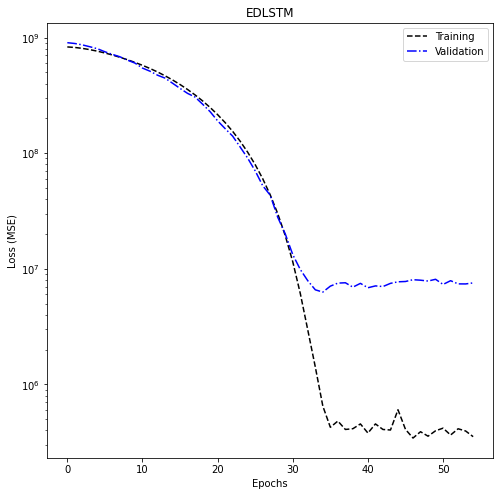

In [ ]:
%%skip $SKIP_RETRAIN_ED_LSTM
fig = plot_learning_curves(histEDLSTM,model_type,f"./{model_type}/learningcurve_{namespace}.png")
fig.show()

Load best model

In [ ]:
#Calling back the best model:
model_best_ED_LSTM = keras.models.load_model(f"./{model_type}/my_best_model_{namespace}.h5")
model_best_ED_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 80)          34240     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 80)          320       
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          37120     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64)          256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 24, 32)            0

In [ ]:
i=1
case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
Y_test_predictions = pd.Series(model_best_ED_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
y_test_filtered = data_y_test0.loc[Y_test_predictions.index]
#y_test_filtered = y_test_filtered.squeeze(axis=1)

In [ ]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

<ipython-input-23-f128fcf0dccf>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


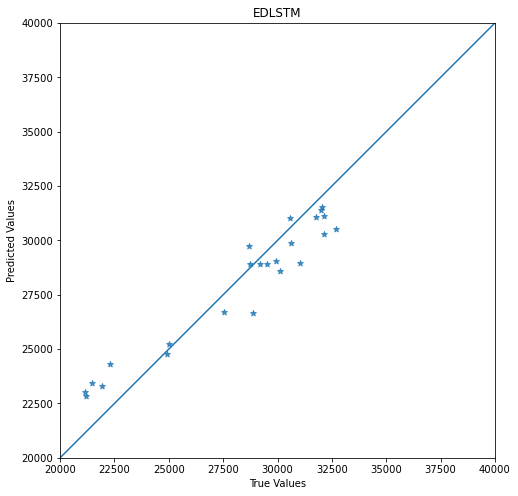

In [ ]:
fig = plot_accuracy(eval_df,model_type,f"./{model_type}/accuracy_{namespace}.png")
fig.show()

<ipython-input-24-05c98d64636b>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


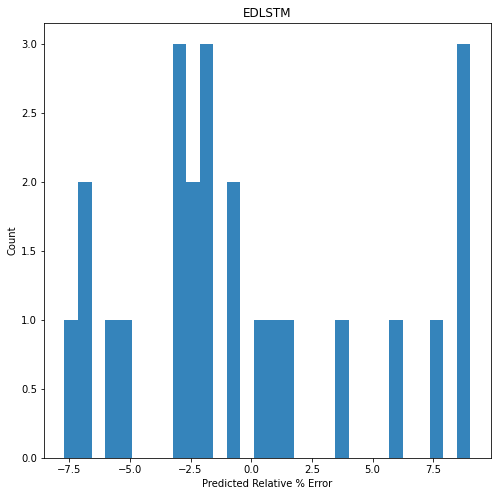

In [ ]:
fig = plot_error_variations(eval_df,model_type,f"./{model_type}/error_variations_{namespace}.png")
fig.show()

In [ ]:
#Calculating the mean absolutepercentage error:
abs_error_ED_LSTM = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_ED_LSTM)

nan

In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.89


<ipython-input-27-65a49c2caced>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


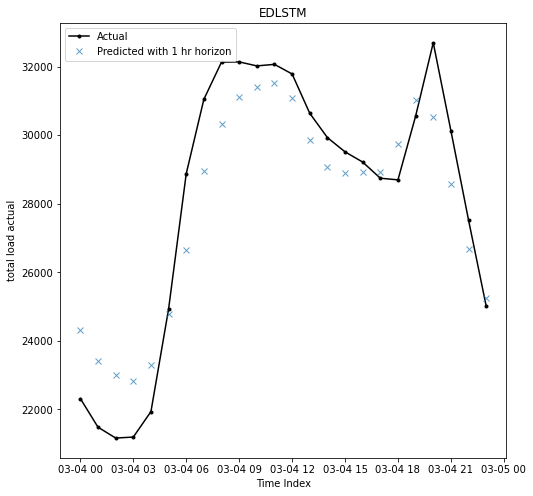

In [ ]:
fig=plot_predictions(eval_df,1,model_type,feature,f"./{model_type}/predictions_{namespace}.png")
fig.show()

In [ ]:
idx_prediction = pd.date_range(start=idx_test[0],freq='h',periods=len(idx_test)+24)
y_test_filtered2 = data_y_test0.loc[idx_prediction]

In [ ]:
fig = go.Figure()
df_pred =pd.DataFrame(index=y_test_filtered2.index)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=y_test_filtered2[feature]))
for i in range(len(data_x_test)):
    case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
    Y_test_predictions = pd.Series(model_best_ED_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
    df_pred[f'pred_{i}'] = Y_test_predictions
    fig.add_trace(go.Scatter(x = Y_test_predictions.index,y=Y_test_predictions,mode='markers'))

df_pred['mean'] = df_pred.mean(axis=1)
df_pred['median'] = df_pred.median(axis=1)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['mean']))
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['median']))
fig.show()
eval_df2  =create_eval_df(df_pred['mean'],y_test_filtered2)

In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered2[:-1],df_pred['mean'][:-1])
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.65


xx


# Hyperparameter Tuning


We may investigate the following parameters:

*   Number of layers
*   Number of nodes
*   Activation function
*   Optimizer
*   Learning rate
*   Number of epochs 
*   Batch size to update the optimization

Other options we can include can be listed as:

*   Adding weight regularization
*   Adding dropout
*   Early stopping / Callback

Scale the input data

In [ ]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [ ]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-14'
feature = 'total load actual'
model_type = 'LSTM'
namespace = 'MS_LSTM_LOAD_HPT'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [ ]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,72,24,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,72,24,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,72,24,32)


In [ ]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

(17416, 72, 26) (17416, 24)
(1288, 72, 26) (1288, 24)
(168, 72, 26) (168, 24)


Define LSTM Model for Hyperparamter Tuning 


In [ ]:
def build_model_LSTM(hp):
  n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
  model = models.Sequential()
  
  model.add(layers.LSTM(hp.Int('Neurons',min_value=16,max_value=96,step=16), return_sequences=True,input_shape=(None, n_features), stateful=False)) 
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(hp.Float('Dropout',min_value=0.1,max_value=0.4,step=0.1)))
  
  for i in range(hp.Int('n_layers',1,4,1)):
    model.add(layers.LSTM(hp.Int('Neurons',min_value=16,max_value=96,step=16), return_sequences=True, stateful=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('Dropout',min_value=0.1,max_value=0.4,step=0.1)))
    
  model.add(layers.LSTM(hp.Int('Neurons',min_value=16,max_value=96,step=16), stateful=False))
  
  model.add(layers.Dense(hp.Int('Neurons',min_value=16,max_value=96,step=16), kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal"),)
  model.add(layers.LeakyReLU(alpha=0.1))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(n_outputs))                     
  
  model.compile(optimizer='Adam',loss='mse',metrics='mae') 
  return model

In [ ]:
tuner = kt.RandomSearch(
    build_model_LSTM,
    objective='val_loss',
    max_trials=10,
    executions_per_trial = 1,
    directory = "./hpt_LSTM/",
    project_name="Load")
tuner.search_space_summary()


INFO:tensorflow:Reloading Oracle from existing project ./hpt_LSTM/DDE_3\oracle.json
INFO:tensorflow:Reloading Tuner from ./hpt_LSTM/DDE_3\tuner0.json
Search space summary
Default search space size: 3
Neurons (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 96, 'step': 16, 'sampling': None}
Dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}


In [ ]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint(f"./{model_type}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [ ]:
num_epochs = 150
batch_size = 32

In [ ]:
tuner.search(data_x_train,data_y_train,epochs=150,validation_data=(data_x_val,data_y_val),batch_size=batch_size,callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in ./hpt_LSTM/DDE_3
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Neurons: 32
Dropout: 0.4
n_layers: 4
Score: 9862256.0
Trial summary
Hyperparameters:
Neurons: 96
Dropout: 0.30000000000000004
n_layers: 4
Score: 11033387.0
Trial summary
Hyperparameters:
Neurons: 64
Dropout: 0.4
n_layers: 1
Score: 11300748.0
Trial summary
Hyperparameters:
Neurons: 48
Dropout: 0.1
n_layers: 2
Score: 11530967.0
Trial summary
Hyperparameters:
Neurons: 96
Dropout: 0.2
n_layers: 1
Score: 11773079.0
Trial summary
Hyperparameters:
Neurons: 32
Dropout: 0.1
n_layers: 1
Score: 12437209.0
Trial summary
Hyperparameters:
Neurons: 32
Dropout: 0.30000000000000004
n_layers: 1
Score: 12732465.0
Trial summary
Hyperparameters:
Neurons: 16
Dropout: 0.4
n_layers: 2
Score: 14758591.0
Trial summary
Hyperparameters:
Neurons: 32
Dropout: 0.2
n_layers: 3
Score: 17999762.0
Trial summary
Hyperparameters:
Neurons: 16
Dropout: 0.30000000000000004
n_layers: 1


In [ ]:
best_models = tuner.get_best_models()
best_hps = tuner.get_best_hyperparameters(5)

In [ ]:
best_hps[0]

In [ ]:
%%skip $SKIP_RETRAIN_LSTM
model_LSTM= build_model_LSTM(best_hps[1])
history_LSTM = model_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])

Epoch 1/150
545/545 [==============================] - 25s 36ms/step - loss: 828600000.0000 - mae: 28428.5254 - val_loss: 900689664.0000 - val_mae: 29591.2109
Epoch 2/150
545/545 [==============================] - 18s 34ms/step - loss: 819652544.0000 - mae: 28287.9160 - val_loss: 879350144.0000 - val_mae: 29246.5625
Epoch 3/150
545/545 [==============================] - 18s 33ms/step - loss: 803455232.0000 - mae: 28023.7031 - val_loss: 866830656.0000 - val_mae: 29034.6309
Epoch 4/150
545/545 [==============================] - 18s 33ms/step - loss: 781707200.0000 - mae: 27657.7578 - val_loss: 826353152.0000 - val_mae: 28367.0781
Epoch 5/150
545/545 [==============================] - 18s 34ms/step - loss: 755834816.0000 - mae: 27205.2773 - val_loss: 776203712.0000 - val_mae: 27466.4805
Epoch 6/150
545/545 [==============================] - 18s 33ms/step - loss: 726603968.0000 - mae: 26676.9434 - val_loss: 720951488.0000 - val_mae: 26419.1641
Epoch 7/150
545/545 [=========================

Evaluate the training process

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

histLSTM = pd.DataFrame(history_LSTM.history)
histLSTM['epoch'] = history_LSTM.epoch

<string>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


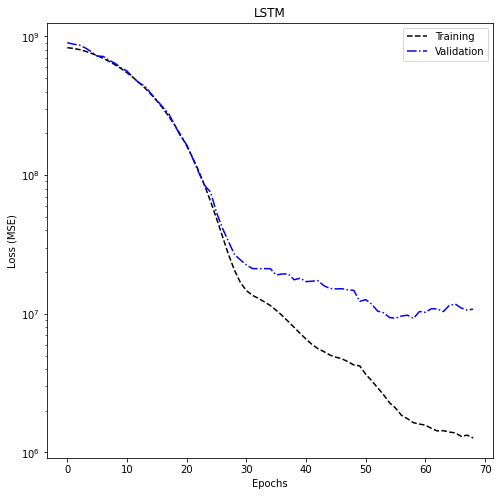

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

fig = plot_learning_curves(histLSTM,model_type,f'./{model_type}/learningcurve_{namespace}.png')
fig.show()

Load best model

In [ ]:
#Calling back the best model:
model_best_MS_LSTM = keras.models.load_model(f"./{model_type}/my_best_model_{namespace}.h5")
model_best_MS_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, None, 96)          47232     
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 96)          384       
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 96)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 96)          74112     
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 96)          384       
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 96)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 96)         

In [ ]:
i=1
case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))

Y_test_predictions = pd.Series(model_best_MS_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
y_test_filtered = data_y_test0.loc[Y_test_predictions.index]


In [ ]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

<ipython-input-25-9e430721b3b7>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


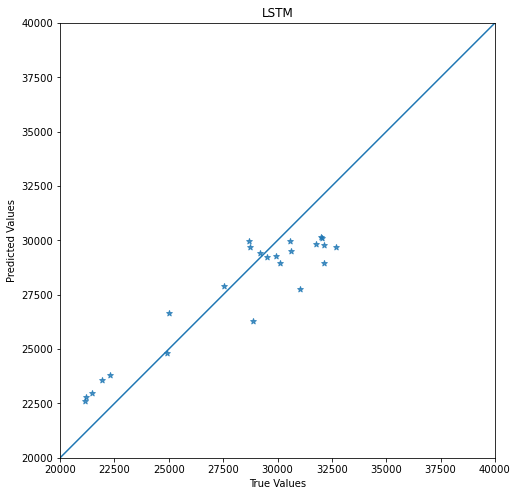

In [ ]:
fig = plot_accuracy(eval_df,model_type,f'./{model_type}/accuracy_{namespace}.png')
fig.show()

<ipython-input-26-7c3e59406e1f>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


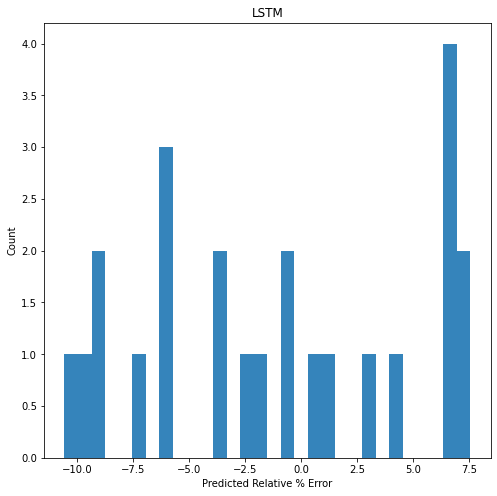

In [ ]:
fig = plot_error_variations(eval_df,model_type,f'./{model_type}/error_variations_{namespace}.png')
fig.show()

In [ ]:
#Calculating the mean absolutepercentage error:
abs_error_LSTM = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_LSTM)

nan

In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.80


<ipython-input-29-60dd1e0473df>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


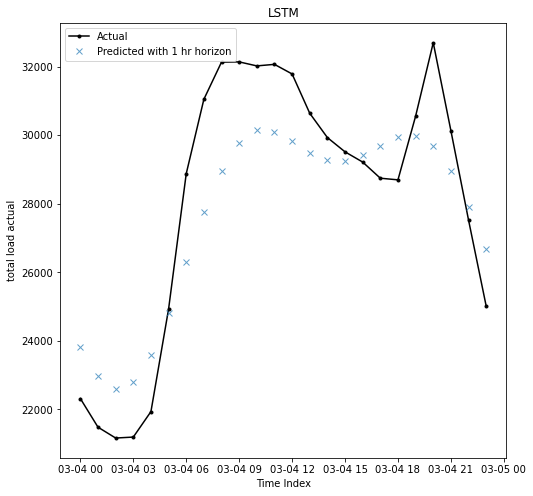

In [ ]:
fig = plot_predictions(eval_df,1,model_type,feature,f'./{model_type}/predictions_{namespace}.png')
fig.show()

In [ ]:
idx_prediction = pd.date_range(start=idx_test[0],freq='h',periods=len(idx_test)+24)
y_test_filtered2 = data_y_test0.loc[idx_prediction]

In [ ]:
fig = go.Figure()
df_pred =pd.DataFrame(index=y_test_filtered2.index)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=y_test_filtered2[feature]))
for i in range(len(data_x_test)):
    case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
    Y_test_predictions = pd.Series(model_best_MS_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
    df_pred[f'pred_{i}'] = Y_test_predictions
    fig.add_trace(go.Scatter(x = Y_test_predictions.index,y=Y_test_predictions,mode='markers'))

df_pred['mean'] = df_pred.mean(axis=1)
df_pred['median'] = df_pred.median(axis=1)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['mean']))
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['median']))
fig.show()
eval_df2  =create_eval_df(df_pred['mean'],y_test_filtered2)

In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered2[:-1],df_pred['mean'][:-1])
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.45


# Conclusion and outlook
